In [10]:
%matplotlib inline
import numpy as np
import time
from matplotlib import pyplot as plt
import matplotlib as mpl
#import seaborn as sns
import scipy 

from scipy.optimize import (minimize, approx_fprime)
from scipy.optimize.optimize import approx_fhess_p
#sns.set()
from IPython.display import Image
from IPython.core.display import HTML 
import timeit
import go_benchmark as gb
from scipy.optimize import fmin_slsqp
import numdifftools as nd
import pandas as pd

In [116]:
import warnings
warnings.filterwarnings('ignore')

In [108]:
from ipywidgets import FloatProgress
from IPython.display import display

In [11]:
from scipy.optimize._trustregion_dogleg import DoglegSubproblem
from scipy.optimize._trustregion_ncg import  CGSteihaugSubproblem
from scipy.optimize._trustregion_exact import IterativeSubproblem

In [12]:
import warnings
import sys
from scipy._lib.six import callable, xrange
from numpy import (atleast_1d, eye, mgrid, argmin, zeros, shape, squeeze,
                   vectorize, asarray, sqrt, Inf, asfarray, isinf)
import numpy as np
from scipy._lib._util import getargspec_no_self as _getargspec


# standard status messages of optimizers
_status_message = {'success': 'Optimization terminated successfully.',
                   'maxfev': 'Maximum number of function evaluations has '
                              'been exceeded.',
                   'maxiter': 'Maximum number of iterations has been '
                              'exceeded.',
                   'pr_loss': 'Desired error not necessarily achieved due '
                              'to precision loss.'}
_epsilon = sqrt(np.finfo(float).eps)
from scipy.optimize._trlib import get_trlib_quadratic_subproblem
from scipy.optimize.optimize import (_LineSearchError, vecnorm, _line_search_wolfe12, wrap_function, OptimizeResult)


In [13]:
from scipy.optimize import line_search

In [14]:
from scipy.optimize.linesearch import line_search_armijo,_nonmonotone_line_search_cheng, _nonmonotone_line_search_cruz,scalar_search_armijo

In [123]:
#stable
def minimize_trust_region (fun, x0, x_opt,  update=None ,args=(), jac=None, hess=None, hessp=None,
                           subproblem=None, initial_trust_radius=1.0,
                           max_trust_radius=1000.0, eta=0.15, gtol=1e-4,
                           maxiter=None, disp=False, return_all=False,
                           callback=None, inexact=True, **unknown_options):
    #_check_unknown_options(unknown_options)

    if update is None:
        raise ValueError('Update formula is currently required for quasi-newton methods ')
        
    if jac is None:
        raise ValueError('Jacobian is currently required for trust-region '
                         'methods')
    if hess is None and hessp is None:
        raise ValueError('Either the Hessian or the Hessian-vector product '
                         'is currently required for trust-region methods')
    if subproblem is None:
        raise ValueError('A subproblem solving strategy is required for '
                         'trust-region methods')
    if not (0 <= eta < 0.25):
        raise Exception('invalid acceptance stringency')
    if max_trust_radius <= 0:
        raise Exception('the max trust radius must be positive')
    if initial_trust_radius <= 0:
        raise ValueError('the initial trust radius must be positive')
    if initial_trust_radius >= max_trust_radius:
        raise ValueError('the initial trust radius must be less than the '
                         'max trust radius')
    
    # force the initial guess into a nice format
    x0 = np.asarray(x0).flatten()

    # Wrap the functions, for a couple reasons.
    # This tracks how many times they have been called
    # and it automatically passes the args.

    nfun, fun = wrap_function(fun, args)
    njac, jac = wrap_function(jac, args)
    nhess, hess = wrap_function(hess, args)
    nhessp, hessp = wrap_function(hessp, args)
    
    # limit the number of iterations
    if maxiter is None:
        maxiter = len(x0)*200

    # init the search status
    warnflag = 0

    # initialize the search
    trust_radius = initial_trust_radius
    x = x0
    if return_all:
        allvecs = [x]
    m = subproblem(x, fun, jac, hess, hessp)
    Bk = hess(x0)
    k = 0
    N = len(x0)
    I = np.eye(N, dtype=int)
    # search for the function min
    # do not even start if the gradient is small enough
    cnorm = np.linalg.norm(x - x_opt)
    
    while (cnorm > gtol and k<maxiter):

        # Solve the sub-problem.
        # This gives us the proposed step relative to the current position
        # and it tells us whether the proposed step
        # has reached the trust region boundary or not.
        try:
            p, hits_boundary = m.solve(trust_radius)
        except (np.linalg.linalg.LinAlgError, ValueError) :
            warnflag = 3
            break

        # calculate the predicted value at the proposed point
        predicted_value = m(p)

        # define the local approximation at the proposed point
        x_proposed = x + p
        
        hess = lambda x: Bk
        nhess, hess = wrap_function(hess, args)
        
        m_proposed = subproblem(x_proposed, fun, jac, hess, hessp)

        # evaluate the ratio defined in equation (4.4)
        actual_reduction = m.fun - m_proposed.fun
        predicted_reduction = m.fun - predicted_value
        if predicted_reduction <= 0:
            warnflag = 2
            break
        rho = actual_reduction / predicted_reduction

        # update the trust radius according to the actual/predicted ratio
        if rho < 0.25:
            trust_radius *= 0.25
        elif rho > 0.75 and hits_boundary:
            trust_radius = min(2*trust_radius, max_trust_radius)

        # if the ratio is high enough then accept the proposed step
        if rho > eta:
            
            sk = p
            yk = m_proposed.jac - m.jac
            #print yk
            if update is 'BFGS':
                A1 = np.dot( Bk, np.dot( (sk[:, np.newaxis] * sk[np.newaxis, :]),Bk ))
                A2 = float(np.dot(sk, np.dot(Bk,sk)))
                A3 = yk[:, np.newaxis] * yk[np.newaxis, :]
                A4 = float(np.dot(yk,sk))
                Bk = Bk - A1/A2 + A3/A4
                
            if update is "DFP":
                gamma = 1.0/np.dot(yk, sk)
                A1 = I - yk[:, np.newaxis] * sk[np.newaxis, :] * gamma
                A2 = I - sk[:, np.newaxis] * yk[np.newaxis, :] * gamma
                Bk = np.dot(A1, np.dot(Bk, A2)) + (gamma * yk[:, np.newaxis] *yk[np.newaxis, :])
                
            if update is "PSB":
                A0 = yk - np.dot(Bk,sk)
                A1 = A0[:, np.newaxis] * sk[np.newaxis, :] + sk[:,np.newaxis]*A0[np.newaxis, :]
                A2 = float(np.dot(sk, sk))
                A3 = np.dot(sk, yk - np.dot(Bk, sk)) * sk[:, np.newaxis] * sk[np.newaxis, :]
                A4 = A2**2
                Bk = Bk + A1/A2 - A3/A4

            if update is "SR1":
                A0 = yk - np.dot(Bk,sk)
                A1 = A0[:, np.newaxis] * A0[np.newaxis, :]
                A2 = float(np.dot(A0, yk))
                Bk = Bk + A1/A2
            
            x = x_proposed
            m = m_proposed

        # append the best guess, call back, increment the iteration count
        if return_all:
            allvecs.append(np.copy(x))
        if callback is not None:
            callback(np.copy(x))
        k += 1

        # check if the gradient is small enough to stop
        cnorm = np.linalg.norm(x - x_opt)
        if cnorm < gtol :
            warnflag = 0
            break

        # check if we have looked at enough iterations
        if k >= maxiter:
            warnflag = 1
            break

    # print some stuff if requested
    status_messages = (
            _status_message['success'],
            _status_message['maxiter'],
            'A bad approximation caused failure to predict improvement.',
            'A linalg error occurred, such as a non-psd Hessian.',
            )
    

    result = OptimizeResult(x=x, success=(warnflag == 0), status=warnflag,
                            fun=m.fun, jac=m.jac, nfev=nfun[0], njev=njac[0],
                            nhev=nhess[0], nit=k,
                            message=status_messages[warnflag])

    if hess is not None:
        result['hess'] = m.hess

    if return_all:
        result['allvecs'] = allvecs

    return result

In [122]:
#stable
def minimize_line_search(fun, x0, x_opt, update=None ,args=(), jac=None,hess=None, callback=None,
                   gtol=1e-3, norm=Inf, eps=_epsilon, maxiter=None,
                   disp=False, return_all=False,
                   **unknown_options):
    
    #_check_unknown_options(unknown_options)
    
    if update is None:
        raise ValueError('Update formula is currently required for quasi-newton methods ')
        
    f = fun
    fprime = jac
    epsilon = eps
    retall = return_all

    x0 = asarray(x0).flatten()
    
    if x0.ndim == 0:
        x0.shape = (1,)
    if maxiter is None:
        maxiter = len(x0) * 200
        
    func_calls, f = wrap_function(f, args)
    
    if fprime is None:
        grad_calls, myfprime = wrap_function(approx_fprime, (f, epsilon))
    else:
        grad_calls, myfprime = wrap_function(fprime, args)
        
    gfk = myfprime(x0)
    k = 0
    N = len(x0)
    s0 = gfk
    y0 = x0 
    I = np.eye(N, dtype=int)
    Hk = I

    # Sets the initial step guess to dx ~ 1
    old_fval = f(x0)
    old_old_fval = old_fval + np.linalg.norm(gfk) / 2

    xk = x0
    if retall:
        allvecs = [x0]
    warnflag = 0
    #gnorm = vecnorm(gfk, ord=norm)
    cnorm = np.linalg.norm(xk - x_opt)
    
    while (cnorm > gtol and k < maxiter):
        
        pk = -np.dot(Hk, gfk)
        try:
            alpha_k, fc, gc, old_fval, old_old_fval, gfkp1 = _line_search_wolfe12(f, myfprime, xk, pk, gfk,
                                              old_fval, old_old_fval, amin=1e-100, amax=1e100)
            
        except _LineSearchError:
            # Line search failed to find a better solution.
            warnflag = 2
            break

        xkp1 = xk + alpha_k * pk
            
            
        if retall:
            allvecs.append(xkp1)
            
        sk = xkp1 - xk
        xk = xkp1
        if gfkp1 is None:
            gfkp1 = myfprime(xkp1)

        yk = gfkp1 - gfk
        gfk = gfkp1
        if callback is not None:
            callback(xk)
            
        k += 1
        #gnorm = vecnorm(gfk, ord=norm)
        cnorm = np.linalg.norm(xk - x_opt)
        if (cnorm <= gtol):
            break
        
        if k >= maxiter:
            warnflag = 1
            break

        if not np.isfinite(old_fval):
            # We correctly found +-Inf as optimal value, or something went
            # wrong.
            warnflag = 2
            break

        try:  # this was handled in numeric, let it remaines for more safety
            rhok = 1.0 / (np.dot(yk, sk))
            
        except ZeroDivisionError:
            rhok = 1000.0
            
            if disp:
                print("Divide-by-zero encountered: rhok assumed large")
        
        if isinf(rhok):  # this is patch for numpy
            rhok = 1000.0
            if disp:
                print("Divide-by-zero encountered: rhok assumed large")
        
        if update is "BFGS":
            A1 = I - sk[:, np.newaxis] * yk[np.newaxis, :] * rhok
            A2 = I - yk[:, np.newaxis] * sk[np.newaxis, :] * rhok
            Hk = np.dot(A1, np.dot(Hk, A2)) + (rhok * sk[:, np.newaxis] *
                                                     sk[np.newaxis, :])

        if update is "DFP":
            A1 = np.dot( Hk, np.dot( (yk[:, np.newaxis] * yk[np.newaxis, :]),Hk ))
            A2 = np.dot(yk, np.dot(Hk,yk))*1.0
            A3 = sk[:, np.newaxis] * sk[np.newaxis, :]
            A4 =  np.dot(yk,sk)*1.0 
            Hk = Hk - A1/A2 + A3/A4
        
        if update is "PSB":
            A0 = sk - np.dot(Hk,yk)
            A1 = A0[:, np.newaxis] * yk[np.newaxis, :] + yk[:,np.newaxis]*A0[np.newaxis, :]
            A2 = float(np.dot(yk, yk))*1.0
            A3 = np.dot(yk, sk - np.dot(Hk, yk)) * yk[:, np.newaxis] * yk[np.newaxis, :]
            A4 = A2**2
            Hk = Hk + A1/A2 - A3/A4
            
        if update is "SR1":
            A0 = sk - np.dot(Hk,yk)
            A1 = A0[:, np.newaxis] * A0[np.newaxis, :]
            A2 = np.dot(A0, yk)*1.0
            Hk = Hk + A1/A2
        
    fval = old_fval
    if np.isnan(fval):
        # This can happen if the first call to f returned NaN;
        # the loop is then never entered.
        warnflag = 2

    if warnflag == 2:
        msg = _status_message['pr_loss']
    elif k >= maxiter:
        warnflag = 1
        msg = _status_message['maxiter']
    else:
        msg = _status_message['success']

    if disp:
        print("%s%s" % ("Warning: " if warnflag != 0 else "", msg))
        print("         Current function value: %f" % fval)
        print("         Iterations: %d" % k)
        print("         Function evaluations: %d" % func_calls[0])
        print("         Gradient evaluations: %d" % grad_calls[0])

    result = OptimizeResult(fun=fval, jac=gfk, hess_inv=Hk, nfev=func_calls[0],
                            njev=grad_calls[0], status=warnflag,
                            success=(warnflag == 0), message=msg, x=xk,
                            nit=k)
    if retall:
        result['allvecs'] = allvecs
    return result

Examples of benchmark functions

$f_{\text{Beale}}(\mathbf{x}) = \left(x_1 x_2 - x_1 + 1.5\right)^{2} + \left(x_1 x_2^{2} - x_1 + 2.25\right)^{2} + \left(x_1 x_2^{3} - x_1 + 2.625\right)^{2}$

$f_{\text{Rosenbrock}}(\mathbf{x}) = \sum_{i=1}^{n-1} [100(x_i^2 - x_{i+1})^2 + (x_i - 1)^2]$
  
$f_{\text{Powell}}(\mathbf{x}) = (x_3+10x_1)^2+5(x_2-x_4)^2+(x_1-2x_2)^4+10(x_3-x_4)^4$

$f_{\text{HelicalValley}}(\mathbf{x}) = 100{[z-10\Psi(x_1,x_2)]^2+(\sqrt{x_1^2+x_2^2}-1)^2}+x_3^2$

$f_{\text{Watson}}(\mathbf{x}) = \sum_{i=0}^{29} \left\{ \sum_{j=0}^4 ((j - 1)a_i^j x_{j+1}) - \left[ \sum_{j=0}^5 a_i^j x_{j+1} \right ]^2 - 1 \right\}^2 + x_1^2$

$f_{\text{Penalty01}}(\mathbf{x}) = \frac{\pi}{30} \left\{10 \sin^2(\pi y_1) + \sum_{i=1}^{n-1} (y_i - 1)^2 \left[1 + 10 \sin^2(\pi y_{i+1}) \right ] + (y_n - 1)^2 \right \} + \sum_{i=1}^n u(x_i, 10, 100, 4)$

$f_{\text{Brown}}(\mathbf{x}) = \sum_{i=1}^{n-1}\left[ \left(x_i^2\right)^{x_{i+1}^2+1} + \left(x_{i+1}^2\right)^{x_i^2+1} \right]$

$f_{\text{Gulf}}(\mathbf{x}) = \sum_{i=1}^m \left( e^{-\frac{\lvert y_i - x_2 \rvert^{x_3}}{x_1}    }  - t_i \right)$

$f_{\text{Trigonometric01}}(\mathbf{x}) = \sum_{i=1}^{n} \left [n - \sum_{j=1}^{n} \cos(x_j) + i \left(1 - cos(x_i) - sin(x_i) \right ) \right]^2$

etc


In [129]:
methods_A_C = {
'Ackley':gb.Ackley(),
'Alpine01':gb.Alpine01(),
'Alpine02':gb.Alpine02(),
'BartelsConn':gb.BartelsConn(),
'Beale':gb.Beale(),
'Bird':gb.Bird(),
'Bohachevsky':gb.Bohachevsky(),
'BoxBetts':gb.BoxBetts(),
'Branin01':gb.Branin01(),
'Branin02':gb.Branin02(),
'Brent':gb.Brent(),
'Brown':gb.Brown(),
'Bukin02':gb.Bukin02(),
'Bukin04':gb.Bukin04(),
'Bukin06':gb.Bukin06(),
'CarromTable':gb.CarromTable(),
'Chichinadze':gb.Chichinadze(),
'Cigar':gb.Cigar(),
'Colville':gb.Colville(),
'Corana':gb.Corana(),
'CosineMixture':gb.CosineMixture(),
'CrossInTray':gb.CrossInTray(),
'CrownedCross':gb.CrownedCross(),
'Csendes':gb.Csendes(),
'Cube':gb.Cube()
}

In [131]:
methods_D_M={
'Damavandi':gb.Damavandi(),
'Deb01':gb.Deb01(),
'Deb02':gb.Deb02(),
'Decanomial':gb.Decanomial(),
'Deceptive':gb.Deceptive(),
'DeckkersAarts':gb.DeckkersAarts(),
'DeflectedCorrugatedSpring':gb.DeflectedCorrugatedSpring(),
'DeVilliersGlasser01':gb.DeVilliersGlasser01(),
'DeVilliersGlasser02':gb.DeVilliersGlasser02(),
'DixonPrice':gb.DixonPrice(),
'Dolan':gb.Dolan(),
'DropWave':gb.DropWave(),
'Easom':gb.Easom(),
'EggCrate':gb.EggCrate(),
'EggHolder':gb.EggHolder(),
'ElAttarVidyasagarDutta':gb.ElAttarVidyasagarDutta(),
'Exp2':gb.Exp2(),
'Exponential':gb.Exponential(),
'FreudensteinRoth':gb.FreudensteinRoth(),
'Gear':gb.Gear(),
'Giunta':gb.Giunta(),
'GoldsteinPrice':gb.GoldsteinPrice(),
'Griewank':gb.Griewank(),
'Gulf':gb.Gulf(),
'Hansen':gb.Hansen(),
'Hartmann3':gb.Hartmann3(),
'Hartmann6':gb.Hartmann6(),
'HelicalValley':gb.HelicalValley(),
'HimmelBlau':gb.HimmelBlau(),
'HolderTable':gb.HolderTable(),
'Infinity':gb.Infinity(),
'JennrichSampson':gb.JennrichSampson(),
'Judge':gb.Judge(),
'Katsuura':gb.Katsuura(),
'Keane':gb.Keane(),
'Kowalik':gb.Kowalik(),
'Langermann':gb.Langermann(),
'Leon':gb.Leon(),
'Levy03':gb.Levy03(),
'Levy05':gb.Levy05(),
'Levy13':gb.Levy13(),
'Matyas':gb.Matyas(),
'McCormick':gb.McCormick(),
'Michalewicz':gb.Michalewicz(),
'Mishra01':gb.Mishra01(),
'Mishra02':gb.Mishra02(),
'Mishra03':gb.Mishra03(),
'Mishra04':gb.Mishra04(),
'Mishra05':gb.Mishra05(),
'Mishra06':gb.Mishra06(),
'Mishra07':gb.Mishra07(),
'Mishra08':gb.Mishra08(),
'Mishra11':gb.Mishra11(),
'MultiModal':gb.MultiModal(), 
}

In [132]:
methods_N_R = {

'NewFunction01':gb.NewFunction01(),
'NewFunction02':gb.NewFunction02(),
'NewFunction03':gb.NewFunction03(),
'OddSquare':gb.OddSquare(),
'Parsopoulos':gb.Parsopoulos(),
'Pathological':gb.Pathological(),
'Paviani':gb.Paviani(),
'Penalty01':gb.Penalty01(),
'Penalty02':gb.Penalty02(),
'PermFunction01':gb.PermFunction01(),
'PermFunction02':gb.PermFunction02(),
'Pinter':gb.Pinter(),
'Plateau':gb.Plateau(),
'Powell':gb.Powell(),
'PowerSum':gb.PowerSum(),
'Price01':gb.Price01(),
'Price02':gb.Price02(),
'Price03':gb.Price03(),
'Price04':gb.Price04(),
'Qing':gb.Qing(),
'Quadratic':gb.Quadratic(),
'Quintic':gb.Quintic(),
'Rana':gb.Rana(),
'Rastrigin':gb.Rastrigin(),
'Ripple01':gb.Ripple01(),
'Ripple25':gb.Ripple25(),
'Rosenbrock':gb.Rosenbrock(),
'RosenbrockModified':gb.RosenbrockModified(),
'RotatedEllipse01':gb.RotatedEllipse01(),
'RotatedEllipse02':gb.RotatedEllipse02(),   
}

In [133]:
methods_S_T = {
'Salomon':gb.Salomon(),
'Sargan':gb.Sargan(),
'Schaffer01':gb.Schaffer01(),
'Schaffer02':gb.Schaffer02(),
'Schaffer03':gb.Schaffer03(),
'Schaffer04':gb.Schaffer04(),
'Schwefel01':gb.Schwefel01(),
'Schwefel02':gb.Schwefel02(),
'Schwefel04':gb.Schwefel04(),
'Schwefel06':gb.Schwefel06(),
'Schwefel20':gb.Schwefel20(),
'Schwefel21':gb.Schwefel21(),
'Schwefel22':gb.Schwefel22(),
'Schwefel26':gb.Schwefel26(),
'Schwefel36':gb.Schwefel36(),
'Shekel05':gb.Shekel05(),
'Shekel07':gb.Shekel07(),
'Shekel10':gb.Shekel10(),
'Shubert01':gb.Shubert01(),
'Shubert03':gb.Shubert03(),
'Shubert04':gb.Shubert04(),
'SineEnvelope':gb.SineEnvelope(),
'SixHumpCamel':gb.SixHumpCamel(),
'Sodp':gb.Sodp(),
'Sphere':gb.Sphere(),
'Step':gb.Step(),
'Stochastic':gb.Stochastic(),
'StretchedV':gb.StretchedV(),
'StyblinskiTang':gb.StyblinskiTang(),
'TestTubeHolder':gb.TestTubeHolder(),
'ThreeHumpCamel':gb.ThreeHumpCamel(),
'Treccani':gb.Treccani(),
'Trefethen':gb.Trefethen(),
'Trid':gb.Trid(),
'Trigonometric01':gb.Trigonometric01(),
'Trigonometric02':gb.Trigonometric02(),
'Tripod':gb.Tripod(),
}

In [135]:
methods_U_Z = {
'Ursem01':gb.Ursem01(),
'Ursem03':gb.Ursem03(),
'Ursem04':gb.Ursem04(),
'UrsemWaves':gb.UrsemWaves(),
'VenterSobiezcczanskiSobieski':gb.VenterSobiezcczanskiSobieski(),
'Vincent':gb.Vincent(),
'Watson':gb.Watson(),
'Wavy':gb.Wavy(),
'WayburnSeader01':gb.WayburnSeader01(),
'WayburnSeader02':gb.WayburnSeader02(),
'Weierstrass':gb.Weierstrass(),
'Whitley':gb.Whitley(),
'Wolfe':gb.Wolfe(),

'YaoLiu04':gb.YaoLiu04(),
'YaoLiu09':gb.YaoLiu09(),
'Zacharov':gb.Zacharov(),
'Zettl':gb.Zettl(),
'Zimmerman':gb.Zimmerman(),
'Zirilli':gb.Zirilli()
}

In [89]:
methods1 = {

'Ackley':gb.Ackley(),
'Alpine01':gb.Alpine01(),
'Alpine02':gb.Alpine02(),
'BartelsConn':gb.BartelsConn(),
'Beale':gb.Beale(),
'Bird':gb.Bird(),
'Bohachevsky':gb.Bohachevsky(),
'BoxBetts':gb.BoxBetts(),
'Branin01':gb.Branin01(),
'Branin02':gb.Branin02(),
'Brent':gb.Brent(),
'Brown':gb.Brown(),
'Bukin02':gb.Bukin02(),
'Bukin04':gb.Bukin04(),
'Bukin06':gb.Bukin06(),
'CarromTable':gb.CarromTable(),
'Chichinadze':gb.Chichinadze(),
'Cigar':gb.Cigar(),
'Colville':gb.Colville(),
'Corana':gb.Corana(),
'CosineMixture':gb.CosineMixture(),
'CrossInTray':gb.CrossInTray(),
'CrownedCross':gb.CrownedCross(),
'Csendes':gb.Csendes(),
'Cube':gb.Cube()
    
'Damavandi':gb.Damavandi(),
'Deb01':gb.Deb01(),
'Deb02':gb.Deb02(),
'Decanomial':gb.Decanomial(),
'Deceptive':gb.Deceptive(),
'DeckkersAarts':gb.DeckkersAarts(),
'DeflectedCorrugatedSpring':gb.DeflectedCorrugatedSpring(),
'DeVilliersGlasser01':gb.DeVilliersGlasser01(),
'DeVilliersGlasser02':gb.DeVilliersGlasser02(),
'DixonPrice':gb.DixonPrice(),
'Dolan':gb.Dolan(),
'DropWave':gb.DropWave(),
'Easom':gb.Easom(),
'EggCrate':gb.EggCrate(),
'EggHolder':gb.EggHolder(),
'ElAttarVidyasagarDutta':gb.ElAttarVidyasagarDutta(),
'Exp2':gb.Exp2(),
'Exponential':gb.Exponential(),
'FreudensteinRoth':gb.FreudensteinRoth(),
'Gear':gb.Gear(),
'Giunta':gb.Giunta(),
'GoldsteinPrice':gb.GoldsteinPrice(),
'Griewank':gb.Griewank(),
'Gulf':gb.Gulf(),
'Hansen':gb.Hansen(),
'Hartmann3':gb.Hartmann3(),
'Hartmann6':gb.Hartmann6(),
'HelicalValley':gb.HelicalValley(),
'HimmelBlau':gb.HimmelBlau(),
'HolderTable':gb.HolderTable(),
'Infinity':gb.Infinity(),
'JennrichSampson':gb.JennrichSampson(),
'Judge':gb.Judge(),
'Katsuura':gb.Katsuura(),
'Keane':gb.Keane(),
'Kowalik':gb.Kowalik(),
'Langermann':gb.Langermann(),
'Leon':gb.Leon(),
'Levy03':gb.Levy03(),
'Levy05':gb.Levy05(),
'Levy13':gb.Levy13(),
'Matyas':gb.Matyas(),
'McCormick':gb.McCormick(),
'Michalewicz':gb.Michalewicz(),
'Mishra01':gb.Mishra01(),
'Mishra02':gb.Mishra02(),
'Mishra03':gb.Mishra03(),
'Mishra04':gb.Mishra04(),
'Mishra05':gb.Mishra05(),
'Mishra06':gb.Mishra06(),
'Mishra07':gb.Mishra07(),
'Mishra08':gb.Mishra08(),
'Mishra11':gb.Mishra11(),
'MultiModal':gb.MultiModal(),
    
'NewFunction01':gb.NewFunction01(),
'NewFunction02':gb.NewFunction02(),
'NewFunction03':gb.NewFunction03(),
'OddSquare':gb.OddSquare(),
'Parsopoulos':gb.Parsopoulos(),
'Pathological':gb.Pathological(),
'Paviani':gb.Paviani(),
'Penalty01':gb.Penalty01(),
'Penalty02':gb.Penalty02(),
'PermFunction01':gb.PermFunction01(),
'PermFunction02':gb.PermFunction02(),
'Pinter':gb.Pinter(),
'Plateau':gb.Plateau(),
'Powell':gb.Powell(),
'PowerSum':gb.PowerSum(),
'Price01':gb.Price01(),
'Price02':gb.Price02(),
'Price03':gb.Price03(),
'Price04':gb.Price04(),
'Qing':gb.Qing(),
'Quadratic':gb.Quadratic(),
'Quintic':gb.Quintic(),
'Rana':gb.Rana(),
'Rastrigin':gb.Rastrigin(),
'Ripple01':gb.Ripple01(),
'Ripple25':gb.Ripple25(),
'Rosenbrock':gb.Rosenbrock(),
'RosenbrockModified':gb.RosenbrockModified(),
'RotatedEllipse01':gb.RotatedEllipse01(),
'RotatedEllipse02':gb.RotatedEllipse02(),
    
'Salomon':gb.Salomon(),
'Sargan':gb.Sargan(),
'Schaffer01':gb.Schaffer01(),
'Schaffer02':gb.Schaffer02(),
'Schaffer03':gb.Schaffer03(),
'Schaffer04':gb.Schaffer04(),
'Schwefel01':gb.Schwefel01(),
'Schwefel02':gb.Schwefel02(),
'Schwefel04':gb.Schwefel04(),
'Schwefel06':gb.Schwefel06(),
'Schwefel20':gb.Schwefel20(),
'Schwefel21':gb.Schwefel21(),
'Schwefel22':gb.Schwefel22(),
'Schwefel26':gb.Schwefel26(),
'Schwefel36':gb.Schwefel36(),
'Shekel05':gb.Shekel05(),
'Shekel07':gb.Shekel07(),
'Shekel10':gb.Shekel10(),
'Shubert01':gb.Shubert01(),
'Shubert03':gb.Shubert03(),
'Shubert04':gb.Shubert04(),
'SineEnvelope':gb.SineEnvelope(),
'SixHumpCamel':gb.SixHumpCamel(),
'Sodp':gb.Sodp(),
'Sphere':gb.Sphere(),
'Step':gb.Step(),
'Stochastic':gb.Stochastic(),
'StretchedV':gb.StretchedV(),
'StyblinskiTang':gb.StyblinskiTang(),
'TestTubeHolder':gb.TestTubeHolder(),
'ThreeHumpCamel':gb.ThreeHumpCamel(),
'Treccani':gb.Treccani(),
'Trefethen':gb.Trefethen(),
'Trid':gb.Trid(),
'Trigonometric01':gb.Trigonometric01(),
'Trigonometric02':gb.Trigonometric02(),
'Tripod':gb.Tripod(),
    
'Ursem01':gb.Ursem01(),
'Ursem03':gb.Ursem03(),
'Ursem04':gb.Ursem04(),
'UrsemWaves':gb.UrsemWaves(),
'VenterSobiezcczanskiSobieski':gb.VenterSobiezcczanskiSobieski(),
'Vincent':gb.Vincent(),
'Watson':gb.Watson(),
'Wavy':gb.Wavy(),
'WayburnSeader01':gb.WayburnSeader01(),
'WayburnSeader02':gb.WayburnSeader02(),
'Weierstrass':gb.Weierstrass(),
'Whitley':gb.Whitley(),
'Wolfe':gb.Wolfe(),

'YaoLiu04':gb.YaoLiu04(),
'YaoLiu09':gb.YaoLiu09(),
'Zacharov':gb.Zacharov(),
'Zettl':gb.Zettl(),
'Zimmerman':gb.Zimmerman(),
'Zirilli':gb.Zirilli()
}

In [19]:
methods = {
'Beale'             :gb.Beale(),
'Rosenbrock'        :gb.Rosenbrock(),
'HelicalValley'     :gb.HelicalValley(),
'Watson'            :gb.Watson(),
'Penalty01'         :gb.Penalty01(),
'Brown'             :gb.Brown(),
'Gulf'              :gb.Gulf(),
'Trigonometric01'   :gb.Trigonometric01(),
'RosenbrockModified':gb.RosenbrockModified(),
'FreudensteinRoth'  :gb.FreudensteinRoth(),
'JennrichSampson'   :gb.JennrichSampson(),
'Kowalik'           :gb.Kowalik(),
'Powell'            :gb.Powell()
}

### Benchmark start

In [73]:
#success results

columns = ['Method',
           'BFGS_LS(suc)','BFGS_LS(time)','BFGS_LS(nit)',
           'DFP_LS(suc)','DFP_LS(time)','DFP_LS(nit)',
           'PSB_LS(suc)','PSB_LS(time)','PSB_LS(nit)',
           'SR1_LS(suc)','SR1_LS(time)','SR1_LS(nit)',
           'BFGS_TR(suc)','BFGS_TR(time)','BFGS_TR(nit)',
           'DFP_TR(suc)','DFP_TR(time)','DFP_TR(nit)',t
           'PSB_TR(suc)','PSB_TR(time)','PSB_TR(nit)',
           'SR1_TR(suc)','SR1_TR(time)','SR1_TR(nit)']
frame = pd.DataFrame(columns=columns )


In [74]:
frame

,Method,BFGS_LS(suc),BFGS_LS(time),BFGS_LS(nit),DFP_LS(suc),PSB_LS(time),PSB_LS(nit),SR1_LS(suc),SR1_LS(time),SR1_LS(nit),...,BFGS_TR(nit),DFP_TR(suc),DFP_TR(time),DFP_TR(nit),PSB_TR(suc),PSB_TR(time),PSB_TR(nit),SR1_TR(suc),SR1_TR(time),SR1_TR(nit)


In [136]:
update1 = ['BFGS','DFP','PSB','SR1']
frame = pd.DataFrame(columns=columns )

In [155]:
methods = methods_U_Z
N = len(methods)
k = 0
for name, obj_fun in methods.items(): 
    new_line= dict.fromkeys(columns)

    new_line['Method'] = name
    func = lambda x: obj_fun.evaluator(x)
    jac = lambda x: approx_fprime (x, func,_epsilon)
    hess = nd.Hessian(f=func)
    
    for upd in update1:
        #jac = nd.Gradient(fun=func)

        N_starts = 30
        s = np.zeros(N_starts, dtype=float)
        nt = np.zeros(N_starts)
        n_suc = 0
        
        for i in range (N_starts):
            x_i=obj_fun.generator()

            hess0 = lambda x: hess(x_i)

            time_start = time.clock()
         
            res = minimize_line_search(fun=func, x0=obj_fun.generator(), x_opt=obj_fun.global_optimum, update=upd, args=(), jac=jac, hess=hess0, hessp=None)
            time_elapsed = (time.clock() - time_start)
           # print name+": "+str(time_elapsed)+' '+str(res.nit)+' '+str(res.status)
            
            if res.status == 0:
                n_suc += 1
            nt[i] = res.nit
            s[i] = time_elapsed
            
        new_line[upd+'_LS(suc)'] = n_suc*1.0/len(s)
        new_line[upd+'_LS(time)'] = np.mean(s)
        new_line[upd+'_LS(nit)'] = np.mean(nt)
        
        n_suc = 0
        
        for i in range (N_starts):
            x_i=obj_fun.generator()

            hess0 = lambda x: hess(x_i)

            time_start = time.clock()
         
            res = minimize_trust_region(fun=func, x0=x_i,x_opt=obj_fun.global_optimum, update=upd, args=(), jac=jac, hess=hess0, hessp=None
                        , subproblem=CGSteihaugSubproblem)
            
            time_elapsed = (time.clock() - time_start)
            #print name+": "+str(time_elapsed)+' '+str(res.nit)+' '+str(res.status)
            
            if res.status == 0:
                n_suc += 1
            nt[i] = res.nit
            s[i] = time_elapsed
            
        new_line[upd+'_TR(suc)'] = n_suc*1.0/len(s)
        new_line[upd+'_TR(time)'] = np.mean(s)
        new_line[upd+'_TR(nit)'] = np.mean(nt)
    k += 1
    sys.stderr.write('%d / %d \n' % (k, N))
    sys.stderr.flush()
    
    frame = frame.append(new_line, ignore_index=True)
         


1 / 19 
2 / 19 
3 / 19 
4 / 19 
5 / 19 
6 / 19 
7 / 19 
8 / 19 
9 / 19 
10 / 19 
11 / 19 
12 / 19 
13 / 19 
14 / 19 
15 / 19 
16 / 19 
17 / 19 
18 / 19 
19 / 19 


In [150]:
frame_D_M.

,Method,BFGS_LS(suc),BFGS_LS(time),BFGS_LS(nit),DFP_LS(suc),PSB_LS(time),PSB_LS(nit),SR1_LS(suc),SR1_LS(time),SR1_LS(nit),...,DFP_TR(nit),PSB_TR(suc),PSB_TR(time),PSB_TR(nit),SR1_TR(suc),SR1_TR(time),SR1_TR(nit),DFP_LS(nit),DFP_LS(time),PSB_LS(suc)
0,Chichinadze,0.000000,0.069489,242.933333,0.033333,0.014317,6.966667,0.000000,0.013389,6.533333,...,81.666667,0.000000,0.031028,107.800000,0.000000,0.036641,121.200000,57.133333,0.021573,0.000000
1,CrossInTray,0.000000,0.040856,141.066667,0.000000,0.010016,12.633333,0.000000,0.010341,9.366667,...,24.766667,0.000000,0.030726,76.000000,0.000000,0.027760,50.933333,16.900000,0.014312,0.000000
2,Bohachevsky,0.266667,0.048802,89.333333,0.133333,0.015411,11.500000,0.166667,0.017929,9.666667,...,52.566667,0.066667,0.038491,21.700000,0.033333,0.055632,60.333333,15.500000,0.023489,0.133333
3,Bird,0.000000,0.020331,64.500000,0.000000,0.007272,8.800000,0.000000,0.006130,7.266667,...,39.966667,0.000000,0.022988,36.900000,0.000000,0.024811,40.933333,37.766667,0.013662,0.000000
4,Brown,0.766667,0.003149,8.033333,0.733333,0.002661,6.933333,0.533333,0.002417,6.233333,...,85.166667,0.966667,0.026283,35.400000,0.566667,0.072475,200.900000,77.500000,0.018786,0.666667
5,Cube,0.900000,0.040379,242.300000,0.033333,0.002311,7.733333,0.000000,0.002074,8.033333,...,316.933333,1.000000,0.029054,81.600000,0.000000,0.088226,400.000000,388.300000,0.059032,0.000000
6,Colville,0.000000,0.014654,17.066667,0.000000,0.020706,30.600000,0.000000,0.004402,9.933333,...,126.966667,0.000000,0.059586,115.066667,0.000000,0.169931,524.533333,18.000000,0.014013,0.000000
7,Cigar,1.000000,0.001597,4.666667,1.000000,0.001319,4.600000,1.000000,0.001205,4.766667,...,9.500000,1.000000,0.017733,9.433333,1.000000,0.018713,11.133333,4.800000,0.001207,1.000000
8,CarromTable,0.000000,0.039409,138.300000,0.000000,0.005836,5.166667,0.000000,0.006515,6.266667,...,35.966667,0.000000,0.024523,48.066667,0.000000,0.030001,60.000000,56.433333,0.018443,0.000000
9,BartelsConn,0.400000,0.012333,9.833333,0.500000,0.005566,6.633333,0.166667,0.008229,7.100000,...,56.033333,0.000000,0.024602,53.166667,0.000000,0.024266,47.066667,11.900000,0.010493,0.000000


In [193]:
frame_A_C.sort_values('Method')

,Method,BFGS_LS(suc),BFGS_LS(time),BFGS_LS(nit),DFP_LS(suc),PSB_LS(time),PSB_LS(nit),SR1_LS(suc),SR1_LS(time),SR1_LS(nit),...,DFP_TR(nit),PSB_TR(suc),PSB_TR(time),PSB_TR(nit),SR1_TR(suc),SR1_TR(time),SR1_TR(nit),DFP_LS(nit),DFP_LS(time),PSB_LS(suc)
10,Ackley,0.000000,0.077531,243.766667,0.066667,0.015666,8.100000,0.000000,0.014443,7.433333,...,96.633333,0.000000,0.045607,170.333333,0.000000,0.036109,102.266667,10.866667,0.018461,0.000000
17,Alpine01,0.033333,0.013379,5.166667,0.000000,0.008579,3.866667,0.000000,0.006993,3.233333,...,64.666667,0.000000,0.044072,129.166667,0.000000,0.028337,73.400000,5.100000,0.012992,0.000000
19,Alpine02,0.300000,0.020211,71.700000,0.100000,0.008607,7.000000,0.266667,0.004471,4.166667,...,97.666667,0.266667,0.024355,80.300000,0.133333,0.032035,138.066667,22.966667,0.012742,0.133333
9,BartelsConn,0.400000,0.012333,9.833333,0.500000,0.005566,6.633333,0.166667,0.008229,7.100000,...,56.033333,0.000000,0.024602,53.166667,0.000000,0.024266,47.066667,11.900000,0.010493,0.000000
23,Beale,0.600000,0.018765,65.866667,0.400000,0.002485,7.833333,0.133333,0.002127,7.400000,...,241.166667,0.566667,0.057597,194.366667,0.166667,0.078899,316.700000,257.500000,0.045203,0.033333
3,Bird,0.000000,0.020331,64.500000,0.000000,0.007272,8.800000,0.000000,0.006130,7.266667,...,39.966667,0.000000,0.022988,36.900000,0.000000,0.024811,40.933333,37.766667,0.013662,0.000000
2,Bohachevsky,0.266667,0.048802,89.333333,0.133333,0.015411,11.500000,0.166667,0.017929,9.666667,...,52.566667,0.066667,0.038491,21.700000,0.033333,0.055632,60.333333,15.500000,0.023489,0.133333
21,BoxBetts,1.000000,0.014513,17.300000,0.066667,0.008202,5.900000,0.633333,0.008301,7.900000,...,11.366667,1.000000,0.083492,9.866667,0.166667,0.494047,533.466667,594.400000,0.419839,0.000000
12,Branin01,0.000000,0.064811,308.866667,0.000000,0.008784,9.400000,0.000000,0.008441,7.933333,...,206.600000,0.000000,0.038864,189.233333,0.000000,0.032575,98.966667,13.066667,0.012704,0.000000
13,Branin02,0.000000,0.015372,49.333333,0.000000,0.006464,8.933333,0.000000,0.006404,7.466667,...,40.833333,0.000000,0.026686,74.066667,0.000000,0.022592,37.533333,11.233333,0.012302,0.000000


In [197]:
frame_U_Z.sort_values('Method')

,Method,BFGS_LS(suc),BFGS_LS(time),BFGS_LS(nit),DFP_LS(suc),PSB_LS(time),PSB_LS(nit),SR1_LS(suc),SR1_LS(time),SR1_LS(nit),...,DFP_TR(nit),PSB_TR(suc),PSB_TR(time),PSB_TR(nit),SR1_TR(suc),SR1_TR(time),SR1_TR(nit),DFP_LS(nit),DFP_LS(time),PSB_LS(suc)
10,Ackley,0.000000,0.077531,243.766667,0.066667,0.015666,8.100000,0.000000,0.014443,7.433333,...,96.633333,0.000000,0.045607,170.333333,0.000000,0.036109,102.266667,10.866667,0.018461,0.000000
17,Alpine01,0.033333,0.013379,5.166667,0.000000,0.008579,3.866667,0.000000,0.006993,3.233333,...,64.666667,0.000000,0.044072,129.166667,0.000000,0.028337,73.400000,5.100000,0.012992,0.000000
19,Alpine02,0.300000,0.020211,71.700000,0.100000,0.008607,7.000000,0.266667,0.004471,4.166667,...,97.666667,0.266667,0.024355,80.300000,0.133333,0.032035,138.066667,22.966667,0.012742,0.133333
9,BartelsConn,0.400000,0.012333,9.833333,0.500000,0.005566,6.633333,0.166667,0.008229,7.100000,...,56.033333,0.000000,0.024602,53.166667,0.000000,0.024266,47.066667,11.900000,0.010493,0.000000
23,Beale,0.600000,0.018765,65.866667,0.400000,0.002485,7.833333,0.133333,0.002127,7.400000,...,241.166667,0.566667,0.057597,194.366667,0.166667,0.078899,316.700000,257.500000,0.045203,0.033333
3,Bird,0.000000,0.020331,64.500000,0.000000,0.007272,8.800000,0.000000,0.006130,7.266667,...,39.966667,0.000000,0.022988,36.900000,0.000000,0.024811,40.933333,37.766667,0.013662,0.000000
2,Bohachevsky,0.266667,0.048802,89.333333,0.133333,0.015411,11.500000,0.166667,0.017929,9.666667,...,52.566667,0.066667,0.038491,21.700000,0.033333,0.055632,60.333333,15.500000,0.023489,0.133333
21,BoxBetts,1.000000,0.014513,17.300000,0.066667,0.008202,5.900000,0.633333,0.008301,7.900000,...,11.366667,1.000000,0.083492,9.866667,0.166667,0.494047,533.466667,594.400000,0.419839,0.000000
12,Branin01,0.000000,0.064811,308.866667,0.000000,0.008784,9.400000,0.000000,0.008441,7.933333,...,206.600000,0.000000,0.038864,189.233333,0.000000,0.032575,98.966667,13.066667,0.012704,0.000000
13,Branin02,0.000000,0.015372,49.333333,0.000000,0.006464,8.933333,0.000000,0.006404,7.466667,...,40.833333,0.000000,0.026686,74.066667,0.000000,0.022592,37.533333,11.233333,0.012302,0.000000


In [152]:
frame_N_R = frame

In [154]:
frame_S_T = frame

In [156]:
frame_U_Z = frame

In [204]:
frame_f = frame_U_Z

In [203]:
frame_U_Z.shape

(165, 25)

In [205]:
frame_f.shape

(165, 25)

In [186]:
frame_f

,Method,BFGS_LS(suc),BFGS_LS(time),BFGS_LS(nit),DFP_LS(suc),PSB_LS(time),PSB_LS(nit),SR1_LS(suc),SR1_LS(time),SR1_LS(nit),...,DFP_TR(nit),PSB_TR(suc),PSB_TR(time),PSB_TR(nit),SR1_TR(suc),SR1_TR(time),SR1_TR(nit),DFP_LS(nit),DFP_LS(time),PSB_LS(suc)
0,Chichinadze,0.000000,0.069489,242.933333,0.033333,0.014317,6.966667,0.000000,0.013389,6.533333,...,81.666667,0.000000,0.031028,107.800000,0.000000,0.036641,121.200000,57.133333,0.021573,0.000000
1,CrossInTray,0.000000,0.040856,141.066667,0.000000,0.010016,12.633333,0.000000,0.010341,9.366667,...,24.766667,0.000000,0.030726,76.000000,0.000000,0.027760,50.933333,16.900000,0.014312,0.000000
2,Bohachevsky,0.266667,0.048802,89.333333,0.133333,0.015411,11.500000,0.166667,0.017929,9.666667,...,52.566667,0.066667,0.038491,21.700000,0.033333,0.055632,60.333333,15.500000,0.023489,0.133333
3,Bird,0.000000,0.020331,64.500000,0.000000,0.007272,8.800000,0.000000,0.006130,7.266667,...,39.966667,0.000000,0.022988,36.900000,0.000000,0.024811,40.933333,37.766667,0.013662,0.000000
4,Brown,0.766667,0.003149,8.033333,0.733333,0.002661,6.933333,0.533333,0.002417,6.233333,...,85.166667,0.966667,0.026283,35.400000,0.566667,0.072475,200.900000,77.500000,0.018786,0.666667
5,Cube,0.900000,0.040379,242.300000,0.033333,0.002311,7.733333,0.000000,0.002074,8.033333,...,316.933333,1.000000,0.029054,81.600000,0.000000,0.088226,400.000000,388.300000,0.059032,0.000000
6,Colville,0.000000,0.014654,17.066667,0.000000,0.020706,30.600000,0.000000,0.004402,9.933333,...,126.966667,0.000000,0.059586,115.066667,0.000000,0.169931,524.533333,18.000000,0.014013,0.000000
7,Cigar,1.000000,0.001597,4.666667,1.000000,0.001319,4.600000,1.000000,0.001205,4.766667,...,9.500000,1.000000,0.017733,9.433333,1.000000,0.018713,11.133333,4.800000,0.001207,1.000000
8,CarromTable,0.000000,0.039409,138.300000,0.000000,0.005836,5.166667,0.000000,0.006515,6.266667,...,35.966667,0.000000,0.024523,48.066667,0.000000,0.030001,60.000000,56.433333,0.018443,0.000000
9,BartelsConn,0.400000,0.012333,9.833333,0.500000,0.005566,6.633333,0.166667,0.008229,7.100000,...,56.033333,0.000000,0.024602,53.166667,0.000000,0.024266,47.066667,11.900000,0.010493,0.000000


In [188]:
frame_f[['BFGS_LS(suc)', 'DFP_LS(suc)','PSB_LS(suc)','SR1_LS(suc)' ]]

,BFGS_LS(suc),DFP_LS(suc),PSB_LS(suc),SR1_LS(suc)
0,0.000000,0.033333,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.266667,0.133333,0.133333,0.166667
3,0.000000,0.000000,0.000000,0.000000
4,0.766667,0.733333,0.666667,0.533333
5,0.900000,0.033333,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000
7,1.000000,1.000000,1.000000,1.000000
8,0.000000,0.000000,0.000000,0.000000
9,0.400000,0.500000,0.000000,0.166667


In [206]:
frame_line_search = pd.DataFrame (data=frame_f[['BFGS_LS(suc)', 'DFP_LS(suc)','PSB_LS(suc)','SR1_LS(suc)' ]])


In [207]:
frame_line_search.shape

(165, 4)

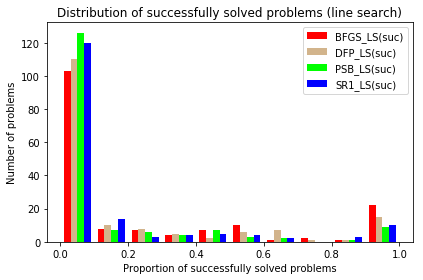

In [376]:
x = frame_line_search.as_matrix()
fig, ax0 = plt.subplots(nrows=1, ncols=1)

colors = ['red', 'tan', 'lime','blue']
labels = ['BFGS_LS(suc)', 'DFP_LS(suc)','PSB_LS(suc)','SR1_LS(suc)' ]
ax0.hist(x, bins=10, histtype='bar', color=colors, label=labels)
ax0.legend(prop={'size': 10})
ax0.set_title('Distribution of successfully solved problems (line search)')
ax0.set_xlabel('Proportion of successfully solved problems')
ax0.set_ylabel('Number of problems')

fig.tight_layout()
fig.savefig('distr_line_search.pdf')

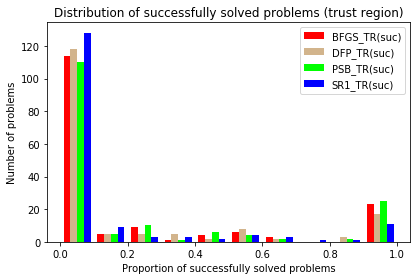

In [377]:
x = frame_trust_region.as_matrix()
fig, ax0 = plt.subplots(nrows=1, ncols=1)

colors = ['red', 'tan', 'lime','blue']
labels = ['BFGS_TR(suc)', 'DFP_TR(suc)','PSB_TR(suc)','SR1_TR(suc)' ]
ax0.hist(x, bins=10, histtype='bar', color=colors, label=labels)
ax0.legend(prop={'size': 10})
ax0.set_title('Distribution of successfully solved problems (trust region)')
ax0.set_xlabel('Proportion of successfully solved problems')
ax0.set_ylabel('Number of problems')

fig.tight_layout()
fig.savefig('distr_trust_region.pdf')

#### Performanse profiling 

Line search

In [247]:
frame_line_search_all=  pd.DataFrame (data=frame_f[
    ['Method',
           'BFGS_LS(suc)','BFGS_LS(time)','BFGS_LS(nit)',
           'DFP_LS(suc)','DFP_LS(time)','DFP_LS(nit)',
           'PSB_LS(suc)','PSB_LS(time)','PSB_LS(nit)',
           'SR1_LS(suc)','SR1_LS(time)','SR1_LS(nit)',
]])

barrier = 0.5
frame_line_search_all_bar = frame_line_search_all[ (frame_line_search['BFGS_LS(suc)'] > barrier)
                  &(frame_line_search['DFP_LS(suc)'] > barrier)
                  &(frame_line_search['PSB_LS(suc)'] > barrier)
                  &(frame_line_search['SR1_LS(suc)'] > barrier)]


frame_line_search_time =pd.DataFrame (data=frame_line_search_all_bar[
    ['BFGS_LS(time)',
    'DFP_LS(time)',
    'PSB_LS(time)',
    'SR1_LS(time)',
]])

frame_line_search_time_matrix = frame_line_search_time.as_matrix()
min_per_row = frame_line_search_time_matrix.min(axis=1)
R_sp = frame_line_search_time_matrix / min_per_row[:,np.newaxis]
n_p = frame_line_search_all_bar.shape[0]

T = 3
solvers = ['BFGS_LS(time)',
    'DFP_LS(time)',
    'PSB_LS(time)',
    'SR1_LS(time)',
]
tau = np.linspace(start=0, stop=T, num=10000)
p_ls = np.zeros((len(solvers), len(tau)))


for i in range(len(solvers)):
    for j in range(len(tau)):
        p_ls[i,j] = 1.0/n_p * len(np.extract(np.log(R_sp[:,i]) < tau[j], R_sp[:,i] )) 

In [339]:
frame_trust_region_all[ (frame_trust_region['SR1_TR(suc)'] > barrier)].shape[0]*1.0/frame_f.shape[0]

0.11515151515151516

In [334]:
frame_trust_region_all_bar.shape[0]*1.0

15.0

Trust region

In [305]:
frame_trust_region_all=  pd.DataFrame (data=frame_f[
    ['Method',
           'BFGS_TR(suc)','BFGS_TR(time)','BFGS_TR(nit)',
           'DFP_TR(suc)','DFP_TR(time)','DFP_TR(nit)',
           'PSB_TR(suc)','PSB_TR(time)','PSB_TR(nit)',
           'SR1_TR(suc)','SR1_TR(time)','SR1_TR(nit)',
]])

barrier = 0.5
frame_trust_region_all_bar = frame_trust_region_all[ (
                    frame_trust_region['BFGS_TR(suc)'] > barrier)
                  &(frame_trust_region['DFP_TR(suc)'] > barrier)
                  &(frame_trust_region['PSB_TR(suc)'] > barrier)
                  &(frame_trust_region['SR1_TR(suc)'] > barrier)]


frame_trust_region_time =pd.DataFrame (data=frame_trust_region_all_bar[
    ['BFGS_TR(time)',
    'DFP_TR(time)',
    'PSB_TR(time)',
    'SR1_TR(time)',
]])

frame_trust_region_time_matrix = frame_trust_region_time.as_matrix()
min_per_row = frame_trust_region_time_matrix.min(axis=1)
R_sp = frame_trust_region_time_matrix / min_per_row[:,np.newaxis]
n_p = frame_trust_region_all_bar.shape[0]

T = 3
solvers = ['BFGS_TR(time)',
    'DFP_TR(time)',
    'PSB_TR(time)',
    'SR1_TR(time)',
]

tau = np.linspace(start=0, stop=T, num=10000)
p_tr = np.zeros((len(solvers), len(tau)))

for i in range(len(solvers)):
    for j in range(len(tau)):
        p_tr[i,j] = 1.0/n_p * len(np.extract(np.log(R_sp[:,i]) < tau[j], R_sp[:,i] )) 

plotting line search

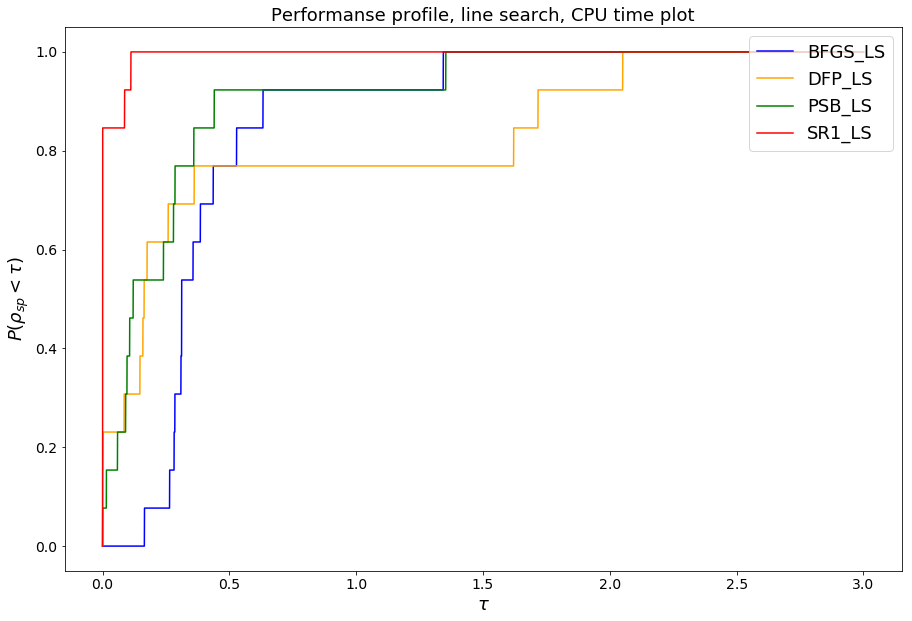

In [348]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))

ax1.plot(tau, p_ls[0,:], label="BFGS_LS", color="blue")
ax1.plot(tau, p_ls[1,:], label="DFP_LS", color="orange")
ax1.plot(tau, p_ls[2,:], label="PSB_LS", color="green")
ax1.plot(tau, p_ls[3,:], label="SR1_LS", color="red")
ax1.set_xlabel(r'$\tau$', fontsize=18)
ax1.set_ylabel(r'$P(\rho_{sp} <\tau)$', fontsize=18)
ax1.set_title ('Performanse profile, line search, CPU time plot', fontsize=18)
ax1.legend(loc = "upper right", fontsize=18)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
#plt.show()

fig.savefig('line_search.pdf')

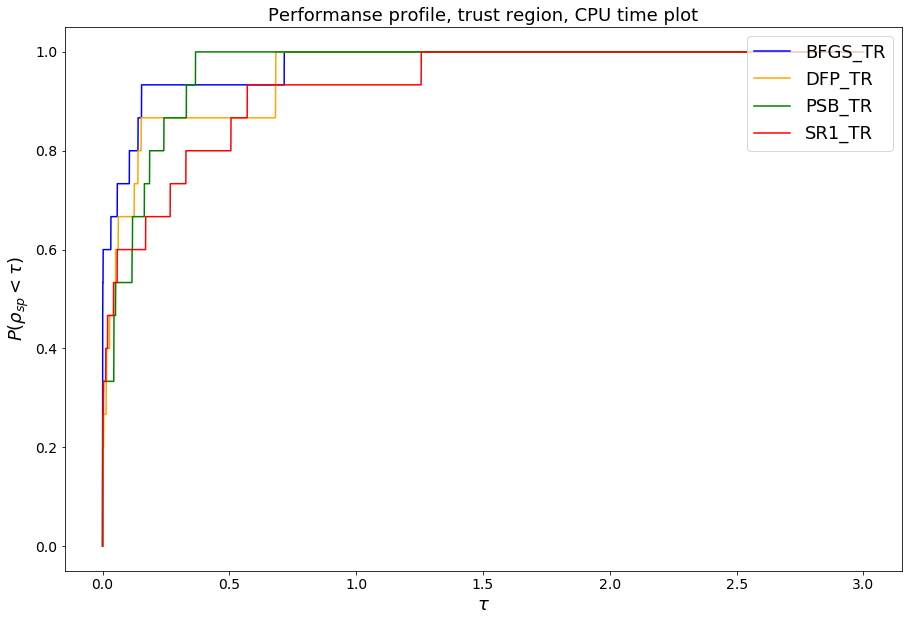

In [349]:
fig, ( ax2) = plt.subplots(1, 1, figsize=(15, 10))

ax2.plot(tau, p_tr[0,:], label="BFGS_TR", color="blue")
ax2.plot(tau, p_tr[1,:], label="DFP_TR", color="orange")
ax2.plot(tau, p_tr[2,:], label="PSB_TR", color="green")
ax2.plot(tau, p_tr[3,:], label="SR1_TR", color="red")
ax2.set_xlabel(r'$\tau$', fontsize=18)
ax2.set_ylabel(r'$P(\rho_{sp} <\tau)$', fontsize=18)
ax2.set_title ('Performanse profile, trust region, CPU time plot', fontsize=18)
ax2.legend(loc = "upper right", fontsize=18)

for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
#plt.show()
fig.savefig('trust_region.pdf')